In [43]:
# import hydromt and functions needed for EVA
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

from hydromt.stats import extremes

In [44]:
station = 1330
# We create some random continuous time series with some extremes
flowdata = pd.read_csv(f"../../../Status_Outlook_Bulletin/stations/data/{station}.csv",parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Convertir el índice a datetime por si acaso
flowdata.index = pd.to_datetime(flowdata.index, dayfirst=True)
diff = pd.date_range(start = flowdata.index[0].strftime('%Y-%m-%d'), end = flowdata.index[-1].strftime('%Y-%m-%d'),freq='D')
# Re-index the dataframe based on the missind date variable
flowdata = flowdata.reindex(diff,fill_value=None)
# Set index Fecha
flowdata.index.name = 'Fecha'
flowdata = flowdata.rename_axis("date")
# Change columns names
flowdata.columns = ['flow']

#month and year column
flowdata['month'] = flowdata.index.month
flowdata['year'] = flowdata.index.year
flowdata = flowdata.reset_index()

#check whether or not there is enough data? 
print(station)
print(f"There are {flowdata['year'].max() - flowdata['year'].min()} years of data in this file.")
print(f"There are {sum(flowdata['flow'].isnull())} missing data points, which is {np.round(sum(flowdata['flow'].isnull())/len(flowdata) * 100,2)}% of the total data")

1330
There are 45 years of data in this file.
There are 1427 missing data points, which is 8.65% of the total data


In [45]:
# Crear DataArray con dimensiones time y stations
da = xr.DataArray(flowdata["flow"].values[:, np.newaxis],
                  coords={"time": flowdata["date"].values,
                          "stations": [station]},
                  dims=["time", "stations"],
                  name="discharge")

# Agregar atributos
da.attrs["long_name"] = "discharge"
da.attrs["units"] = "m3/s"

# Verificar el tipo de coordenada temporal
da

<xarray.DataArray 'discharge' (time: 16496, stations: 1)>
array([[1.956],
       [1.956],
       [1.956],
       ...,
       [4.235],
       [4.119],
       [2.644]])
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2025-02-28
  * stations  (stations) int32 1330
Attributes:
    long_name:  discharge
    units:      m3/s

## Step 1: Extracting peaks from continuous time series

In [46]:
# We use the get_peaks function
bm_peaks = extremes.get_peaks(da, ev_type="BM", period="year")

In [47]:
import plotly.graph_objects as go

# Convertir a DataFrame
df_da = da.to_pandas()
df_peaks = bm_peaks.to_pandas()

# Crear figura
fig = go.Figure()

# Agregar serie de caudales
fig.add_trace(go.Scatter(
    x=df_da.index,
    y=df_da.iloc[:, 0],
    mode='lines',
    name='Discharge',
    line=dict(color='orange')
))

# Agregar los picos (Block Maxima)
fig.add_trace(go.Scatter(
    x=df_peaks.index,
    y=df_peaks.iloc[:, 0],
    mode='markers',
    name='Annual peaks',
    marker=dict(color='red', size=6, symbol='circle')
))

# Layout
fig.update_layout(
    title=f"Discharge time series and annual peaks - Station {station}",
    xaxis_title="Time",
    yaxis_title="Discharge [m³/s]",
    height=400
)

fig.show()


## Step 2: fit a EV distribution on these peaks 

In [48]:
da_params = extremes.fit_extremes(bm_peaks, ev_type="BM", distribution="gev")
da_params.load()

<xarray.DataArray 'parameters' (dparams: 3)>
array([7.04153925e-02, 1.13885329e+03, 6.86014983e+02])
Coordinates:
    stations       int32 1330
    extremes_rate  float64 1.019
  * dparams        (dparams) <U5 'shape' 'loc' 'scale'
    distribution   <U3 'gev'

## Step 3: obtain return values for given return periods based on the distribution fitted and its parameters

In [49]:
# We define the return periods for which we would like to know the return values
rps = np.array([2, 5, 25, 50, 100, 500])
da_rps = extremes.get_return_value(da_params, rps=rps).load()
da_rps.to_pandas()

rps
2      1404.701429
5      2128.051804
25     3113.818857
50     3489.071602
100    3843.670810
500    4599.446773
dtype: float64

In [51]:
df_table = da_rps.to_dataframe(name="Discharge (m³/s)")
df_table.index.name = "T (years)"
df_table_reset = df_table.reset_index()

# Redondear valores
df_table_reset["T (years)"] = df_table_reset["T (years)"].astype(int)
df_table_reset["Discharge (m³/s)"] = df_table_reset["Discharge (m³/s)"].round(2)
df_table_reset = df_table_reset.drop(columns=['stations', 'extremes_rate','distribution'])
df_table_reset


,T (years),Discharge (m³/s)
0,2,1404.70
1,5,2128.05
2,25,3113.82
3,50,3489.07
4,100,3843.67
5,500,4599.45


## Step 4: plot the distribution and empirical data

In [52]:
da_params = da_params.expand_dims("stations")
da_params = da_params.assign_coords(stations=[station])  # Asegura el valor correcto

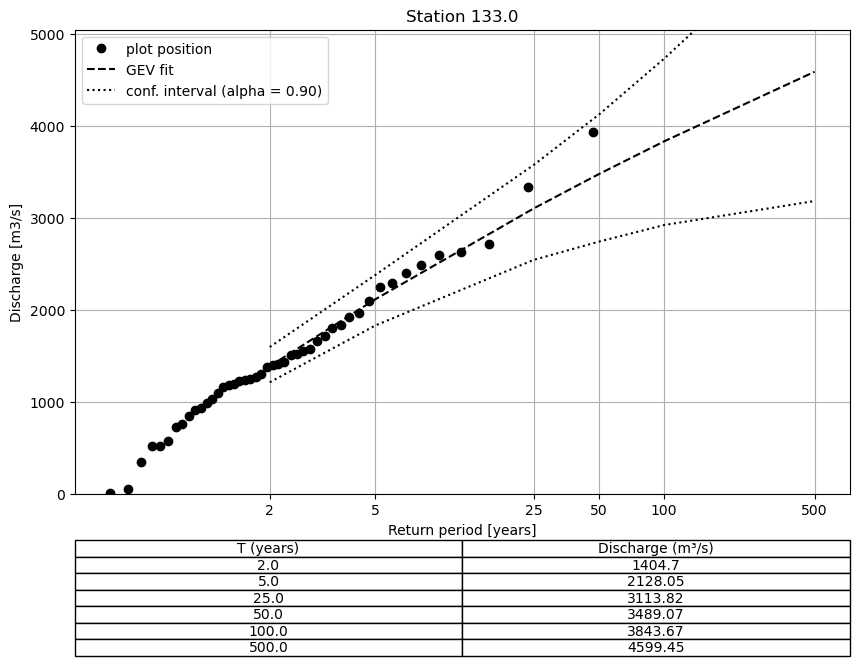

In [ ]:
# We plot the fit obtained using the function plot_return_values!
station_name = float(station)/10
fig, ax = plt.subplots(figsize=(10, 8),sharex=True)

extremes.plot_return_values(bm_peaks.sel(stations=station),
                            da_params.sel(stations=station),
                            "gev",
                            color="black",
                            nsample=1000,
                            rps=rps,
                            extremes_rate=1.0,
                            ax=ax)

table = plt.table(cellText=df_table_reset.values,
                  colLabels=df_table_reset.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.35, 1, 0.25])

plt.subplots_adjust(bottom=0.3)


ax.set_title(f"Station {station_name}");
ax.set_ylabel("Discharge [m3/s]");
ax.set_xlabel("Return period [years]");